In [6]:
pip install ace_tools_open

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import ace_tools_open as tools

In [2]:
data = pd.read_csv('data_football_ratings.csv')

In [3]:
pivot_data = data.pivot_table(values='original_rating', index='team', columns='rater', aggfunc=np.mean)

# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_data.fillna(0)) 
# Clusturing
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
pivot_data['Cluster_country'] = clusters

tools.display_dataframe_to_user("Groupes par Similarités", pivot_data)

Groupes par Similarités


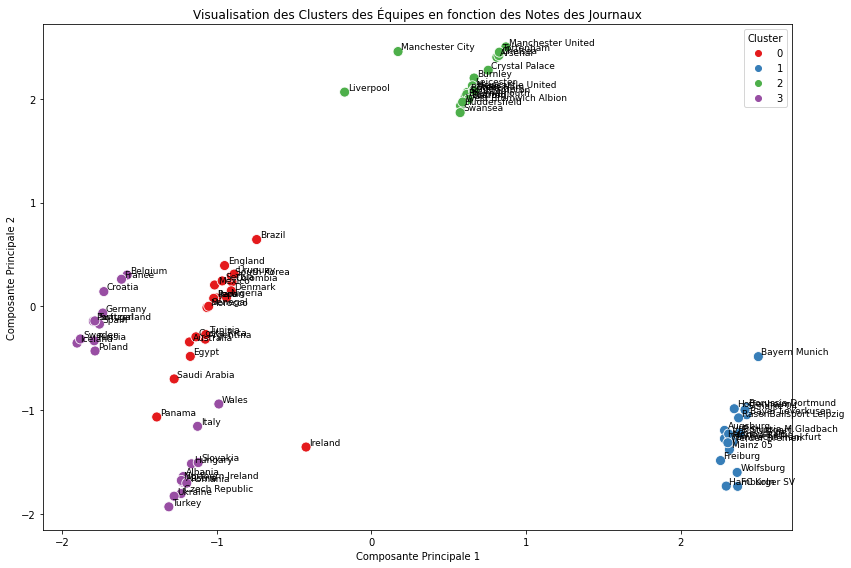

In [4]:
# Réduction de la dimensionnalité pour la visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Ajout des résultats PCA pour la visualisation
pivot_data['PCA1'] = pca_result[:, 0]
pivot_data['PCA2'] = pca_result[:, 1]

# Visualisation des clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_country', data=pivot_data, palette='Set1', s=100)

# Annotation des points avec le nom des équipes
for i in range(pivot_data.shape[0]):
    plt.text(pivot_data['PCA1'].iloc[i]+0.02, pivot_data['PCA2'].iloc[i]+0.02, 
             pivot_data.index[i], fontsize=9)

plt.title('Visualisation des Clusters des Équipes en fonction des Notes des Journaux')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()


In [5]:
# Définir les listes de clubs et d'équipes pour chaque catégorie
english_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham', 'Watford', 'West Bromwich Albion',
                'Huddersfield', 'Leicester', 'Everton', 'Stoke', 'Southampton', 'Swansea','Bournemouth', 'Crystal Palace', 'Brighton', 'Newcastle United', 'West Ham']
german_clubs = ['Bayern Munich', 'Borussia Dortmund', 'RB Leipzig', 'Augsburg', 'Werder Bremen', 'Schalke 04', 'Wolfsburg', 'Bayer Leverkusen', 'Hamburger SV',
               'RasenBallsport Leipzig', 'Hannover 96', 'VfB Stuttgart', 'Mainz 05', 'Hoffenheim', 'Hertha Berlin',	'Borussia M.Gladbach', 'FC Koln',
                'Eintracht Frankfurt', 'Freiburg']
european_national_teams = ['France', 'Germany', 'Italy', 'Spain', 'Portugal', 'Netherlands', 'Belgium', 'England', 'Romania', 'Albania', 'Austria', 'Switzerland', 'Croatia', 
                           'Czech Republic', 'Denmark', 'Iceland', 'Ireland', 'Northern Ireland', 'Poland', 'Russia', 'Serbia',	'Slovakia', 'Sweden', 'Turkey', 'Ukraine', 'Wales']
rest_of_world_national_teams = list(set(data['team'].unique()) - set(english_clubs) - set(german_clubs) - set(european_national_teams))

# Création des colonnes dummies
data['English_Club'] = data['team'].apply(lambda x: 1 if x in english_clubs else 0)
data['German_Club'] = data['team'].apply(lambda x: 1 if x in german_clubs else 0)
data['European_National_Team'] = data['team'].apply(lambda x: 1 if x in european_national_teams else 0)
data['Rest_of_World_National_Team'] = data['team'].apply(lambda x: 1 if x in rest_of_world_national_teams else 0)

In [6]:
dummies = ['English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team']
count_by_dummy_correct = data.melt(id_vars=['rater'], value_vars=dummies, var_name='Category', value_name='Is_Present')
count_summary = count_by_dummy_correct[count_by_dummy_correct['Is_Present'] == 1].groupby(['Category', 'rater']).size().unstack(fill_value=0)

# Affichage du tableau
tools.display_dataframe_to_user("Nombre de joueurs notés par chaque journal pour chaque catégorie de dummies (correct)", count_summary)

Nombre de joueurs notés par chaque journal pour chaque catégorie de dummies (correct)


In [7]:
# Définition des nationalités des journaux
journal_nationalities = {
    'Bild': 'Germany',
    'Kicker': 'Germany',
    'SkySports': 'UK',
    'SofaScore': 'Int',
    'TheGuardian': 'UK',
    'WhoScored': 'Int'
}

# Création des colonnes dummies pour chaque nationalité
for nationality_rater in set(journal_nationalities.values()):
    data[nationality_rater] = data['rater'].apply(lambda x: 1 if journal_nationalities.get(x) == nationality_rater else 0)

In [8]:
team_nationality_map = data[['team', 'English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team']].drop_duplicates()

# Création d'une colonne pour la nationalité de l'équipe
def get_team_nationality(row):
    if row['English_Club'] == 1:
        return 'English Club'
    elif row['German_Club'] == 1:
        return 'German Club'
    elif row['European_National_Team'] == 1:
        return 'European National Team'
    elif row['Rest_of_World_National_Team'] == 1:
        return 'Rest of World National Team'
    else:
        return 'Unknown'

team_nationality_map['Team_Nationality'] = team_nationality_map.apply(get_team_nationality, axis=1)

data = data.merge(team_nationality_map[['team', 'Team_Nationality']], on='team', how='left')

# Attribution de la nationalité des journaux
def get_journal_nationality(rater):
    return journal_nationalities.get(rater, 'Other')

data['Journal_Nationality'] = data['rater'].apply(get_journal_nationality)

In [10]:
avg_ratings = data.groupby(['team', 'Team_Nationality', 'Journal_Nationality'])['original_rating'].mean().reset_index()
non_international_journals = ['Germany', 'UK']
avg_ratings_sorted = avg_ratings.sort_values(by='Team_Nationality')
filtered_avg_ratings = avg_ratings_sorted[avg_ratings_sorted['Journal_Nationality'].isin(non_international_journals)]

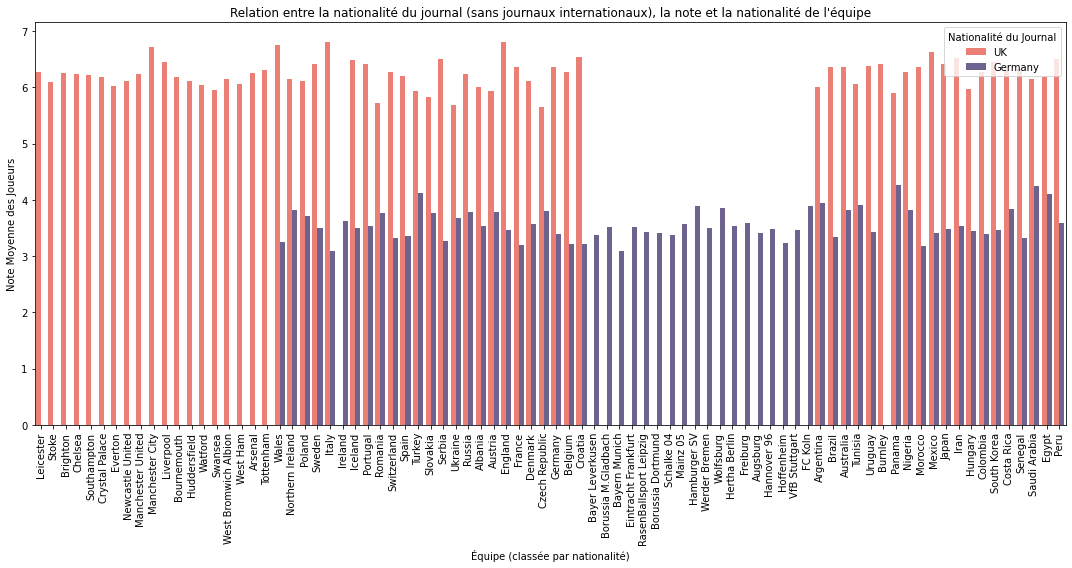

In [13]:
plt.figure(figsize=(15, 8))
sns.barplot(x='team', y='original_rating', hue='Journal_Nationality', data=filtered_avg_ratings, palette = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1'])
plt.title('Relation entre la nationalité du journal (sans journaux internationaux), la note et la nationalité de l\'équipe')
plt.xlabel('Équipe (classée par nationalité)')
plt.ylabel('Note Moyenne des Joueurs')
plt.xticks(rotation=90)
plt.legend(title='Nationalité du Journal')

plt.tight_layout()
plt.show()

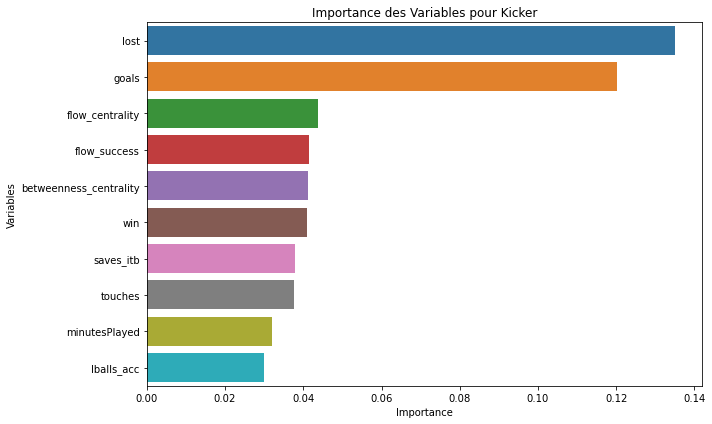

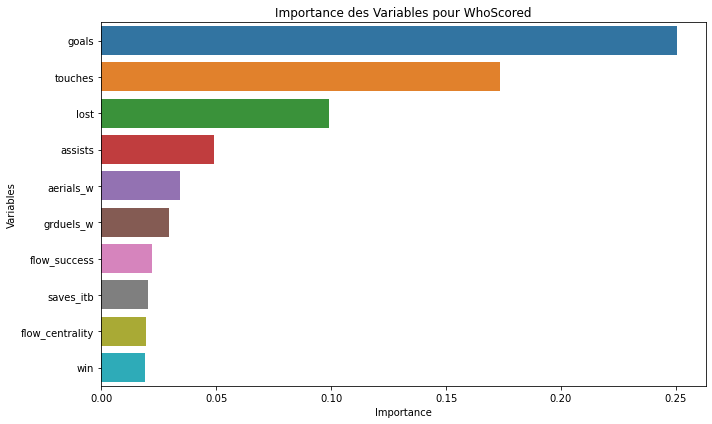

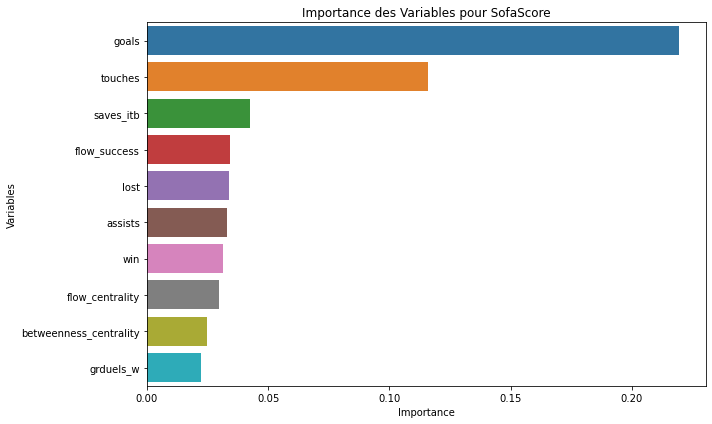

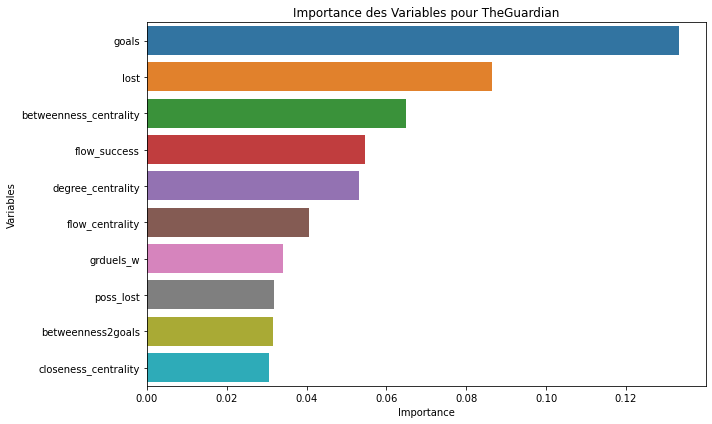

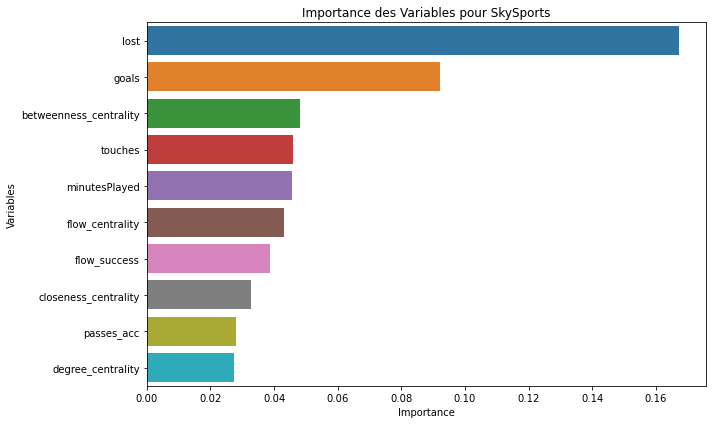

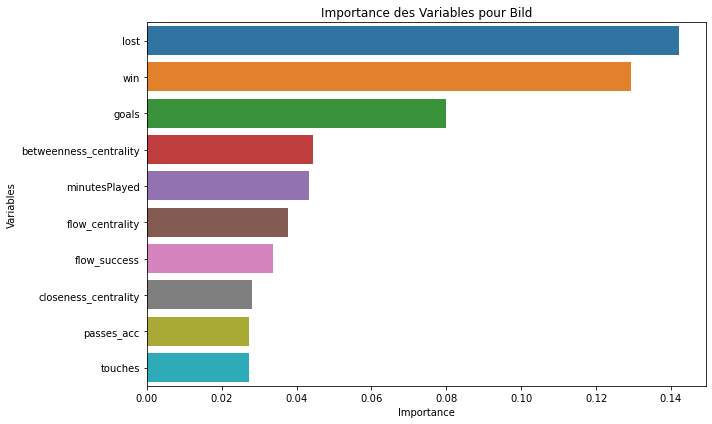


Importance des variables pour Kicker:
lost                      0.135117
goals                     0.120091
flow_centrality           0.043762
flow_success              0.041449
betweenness_centrality    0.041121
win                       0.041072
saves_itb                 0.037954
touches                   0.037695
minutesPlayed             0.031972
lballs_acc                0.030034
dtype: float64

Importance des variables pour WhoScored:
goals              0.250433
touches            0.173645
lost               0.099121
assists            0.049048
aerials_w          0.034355
grduels_w          0.029527
flow_success       0.022116
saves_itb          0.020075
flow_centrality    0.019373
win                0.019099
dtype: float64

Importance des variables pour SofaScore:
goals                     0.219438
touches                   0.115876
saves_itb                 0.042662
flow_success              0.034349
lost                      0.034045
assists                   0.032932
win    

In [15]:
data = pd.read_csv('data_football_ratings.csv')

exclude_columns = ['competition', 'date', 'match', 'team', 'pos', 'pos_role', 'player', 'rater', 'original_rating']
features = data.drop(columns=exclude_columns)
features = features.fillna(0)
journals = data['rater'].unique()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

feature_importance_dict = {}

for journal in journals:
    
    journal_data = data[data['rater'] == journal]
    journal_features = journal_data.drop(columns=exclude_columns)
    journal_target = journal_data['original_rating']
    journal_scaled_features = scaler.fit_transform(journal_features.fillna(0))

    X_train, X_test, y_train, y_test = train_test_split(journal_scaled_features, journal_target, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    importance = model.feature_importances_
    feature_importance = pd.Series(importance, index=journal_features.columns)
    feature_importance_dict[journal] = feature_importance.sort_values(ascending=False)

    # Viz
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance.sort_values(ascending=False).values[:10], 
                y=feature_importance.sort_values(ascending=False).index[:10])
    plt.title(f'Importance des Variables pour {journal}')
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()

for journal, importance in feature_importance_dict.items():
    print(f"\nImportance des variables pour {journal}:")
    print(importance.head(10))